<a href="https://colab.research.google.com/github/soumyadip1997/QA/blob/main/QA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set the Runtime->Change Runtime Type to GPU**

# Protein 3d structure assessment with graph neural networks

In [1]:
!rm -r Data
!rm -r QA
!pip install biopython
!git clone https://github.com/soumyadip1997/QA
!unzip QA/Data.zip
!pip install py3Dmol


rm: cannot remove 'Data': No such file or directory
rm: cannot remove 'QA': No such file or directory
     |████████████████████████████████| 2.3 MB 5.1 MB/s 
Cloning into 'QA'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 104 (delta 55), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (104/104), 21.16 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Archive:  QA/Data.zip
   creating: Data/
   creating: Data/train_data/
   creating: Data/train_data/T0759-D1/
  inflating: Data/train_data/T0759-D1/T0759TS011_4-D1  
  inflating: Data/train_data/T0759-D1/T0759TS022_3-D1  
  inflating: Data/train_data/T0759-D1/T0759TS022_1-D1  
  inflating: Data/train_data/T0759-D1/T0759TS026_5-D1  
  inflating: Data/train_data/T0759-D1/T0759TS026_2-D1  
  inflating: Data/train_data/T0759-D1/T0759TS022_5-D1  
  inflating: Data/train_data/T0759-D1/T0759TS014_5-D1  
  inflating

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset
from torch.utils.data import sampler
import glob
import torch.optim as optim
import pandas as pd
from QA.data_import import get_dataloader,data1
import matplotlib.pyplot as plt
from QA.train import train
from QA.test import test
seed=3
torch.manual_seed(seed)


In [3]:
import py3Dmol
#taken from https://william-dawson.github.io/using-py3dmol.html
print("Target")
with open("QA/T0759-D1.pdb") as ifile:
    file_info_target = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(file_info_target)
view.setStyle({'model': -1}, {"cartoon": {'color': 'blue'}})
view.zoomTo()
view.show()
print("Decoy")
with open("QA/T0759TS499_1-D1.pdb") as ifile:
    file_info_decoy = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(file_info_decoy)
view.setStyle({'model': -1}, {"cartoon": {'color': 'salmon'}})
view.zoomTo()
view.show()

Target


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Decoy


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#The Graph Neural Network

### Input features

1. One hot encoded atom information

2. One hot encoded residue information

### GCN update equations


$$
h_{i}^{(l)}=\sigma\left( W_{\mathrm{center}}^{(l)} h_i^{(l-1)}  +\frac{1}{|\mathcal{N}_{\mathrm{same}}(i)|}\sum_{j\in \mathcal{N}_{\mathrm{same}}(i)}{W_{\mathrm{same}}^{(l)} h_j^{(l-1)}  } +\frac{1}{|\mathcal{N}_{\mathrm{other}}(i)|}\sum_{j\in \mathcal{N}_{\mathrm{other}}(i)}{W_{\mathrm{other}}^{(l)} h_j^{(l-1)} } \right)
$$


$$
h_{i}^{(1)}=\sigma\left( W_{\mathrm{center}}^{(0)} h_i^{(0)} + W_{\mathrm{residue}} r_i +\frac{1}{|\mathcal{N}_{\mathrm{same}}(i)|}\sum_{j\in \mathcal{N}_{\mathrm{same}}(i)}{W_{\mathrm{same}}^{(0)} h_j^{(0)}  } +\frac{1}{|\mathcal{N}_{\mathrm{other}}(i)|}\sum_{j\in \mathcal{N}_{\mathrm{other}}(i)}{W_{\mathrm{other}}^{(0)} h_j^{(0)} } \right)
$$

$h_i^{(0)}$: atom one-hot-encoding

$r_i$ residue one-hot-encoding

$\mathcal{N}_{\mathrm{same}}(i)$: the set of neighbouring atoms of atom $i$ that are within the same residue


$\mathcal{N}_{\mathrm{other}}(i)$: the set of neighbouring atoms of atom $i$ that are from different residues

$\sigma$: the activation function





### Steps for computing GCN output

In the following example we assume four different atom types: Carbon, Oxygen, Nitrogen, and Hydrogen.  Their one-hot-encoding is  [1,0,0,0] ,[0,1,0,0],[0,0,1,0] and [0,0,0,1], respectively.

#### Computing the node signals, $W_{\mathrm{center}}^{(0)} h^{(0)}$:


In [4]:
one_hot_encoded_atom=torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],dtype=torch.float32)
Wv = torch.randn(4, 10)
node_signals=one_hot_encoded_atom @ Wv
node_signals

tensor([[-0.0766,  0.3599, -0.7820,  0.0715,  0.6648, -0.2868,  1.6206, -1.5967,
         -0.0517, -0.3060],
        [ 0.2485, -0.2226,  0.9132,  0.2043,  0.5740,  0.4163,  0.2615,  0.9311,
         -0.5145, -1.6517],
        [ 1.0460,  0.5222, -0.1668,  0.0530, -1.1963,  1.0280,  0.0719, -0.1845,
         -1.5159,  0.9125],
        [ 0.2539, -0.6924,  0.5616, -0.2481, -1.0800,  0.5916,  0.7242, -0.3492,
         -0.5290, -0.6895]])

#### Computing $\frac{1}{|\mathcal{N}_{i}|}\sum_{j\in \mathcal{N}_{i}} W_{\mathrm{neighbors}}^{(l)} h_j^{(l-1)} $


In [5]:
import torch
# neigh_info:
# the indices of the closest neighbours of the atoms of a protein. 
# In this example we have 4 atoms with 3 neighbours per atom. 
# If no neighbour is present, the index is -1.
neigh_info=torch.tensor(
                         [            
                          [1,3,-1],   #neighbours of first atom 
                          [0,2,-1],   #neighbours of second atom 
                          [1,3,-1],   #neighbours of third atom 
                          [2,0,-1]    #neighbours of fourth atom 
                         ]
                        )
atom_feat=torch.randn((4,6))
# atom_feat: 
# the features of all the atoms in a protein
# Its dimensionality is [4,6] where  4 is the number of atoms and 6 is dimensionality
# of the embedding space of each atom

neigh_info.shape

torch.Size([4, 3])

In [6]:
print(f'Atom features \n{atom_feat}')
print(f'Neighbour information \n{neigh_info}')

Atom features 
tensor([[ 0.6197,  1.9097, -1.5781,  0.5071,  0.2030, -0.2044],
        [-0.4121,  0.6874,  0.1870, -0.1813, -0.0914, -0.7349],
        [ 1.9859,  0.3625, -1.3898, -0.1593,  0.3290,  0.3323],
        [ 0.3025, -0.9812,  1.1038, -0.0127, -0.6851, -0.3094]])
Neighbour information 
tensor([[ 1,  3, -1],
        [ 0,  2, -1],
        [ 1,  3, -1],
        [ 2,  0, -1]])


Computing the neighbour signals

In [7]:
W_n = torch.randn((6,10),dtype=torch.float32)
neigh_signals=atom_feat@W_n 
neigh_signals

tensor([[-2.5291e+00,  1.5964e+00, -1.7827e+00,  6.6213e+00,  5.1518e-01,
         -1.5812e+00, -3.2709e-01, -4.6083e-01,  5.3199e-01, -3.1193e+00],
        [ 2.5017e+00,  1.8114e+00, -1.5532e+00,  3.1614e-01, -6.8568e-01,
         -1.2729e+00, -4.3150e-01, -3.1160e-02,  6.8073e-01,  5.7227e-01],
        [-4.4771e+00, -1.4168e+00,  6.7928e-02,  3.6683e+00,  7.1513e-01,
          2.1999e+00, -1.1692e+00, -4.4002e-02, -5.3678e-01, -5.1071e-01],
        [ 2.6326e+00,  5.3903e-02, -2.9728e-01, -4.6095e+00, -5.6146e-03,
          2.1165e-01,  5.1712e-01,  1.7492e-01, -3.2962e-01,  3.9706e+00]])

Boolean matrix that indicates presence of a neighboring atom:

In [8]:
neigh_indicator=(neigh_info>-1)
neigh_indicator

tensor([[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]])

Reshaping it:

In [9]:
unsqueezed_neigh_indicator=neigh_indicator.unsqueeze(2)
unsqueezed_neigh_indicator

tensor([[[ True],
         [ True],
         [False]],

        [[ True],
         [ True],
         [False]],

        [[ True],
         [ True],
         [False]],

        [[ True],
         [ True],
         [False]]])

Now its shape matches the shape of the neighbor signals:

In [10]:
unsqueezed_neigh_indicator.shape, neigh_signals[neigh_info].shape

(torch.Size([4, 3, 1]), torch.Size([4, 3, 10]))

Next, we compute the features of neighbouring atoms:

In [11]:
neigh_features=neigh_signals[neigh_info]*unsqueezed_neigh_indicator
print (neigh_features.shape)
neigh_features

torch.Size([4, 3, 10])


tensor([[[ 2.5017e+00,  1.8114e+00, -1.5532e+00,  3.1614e-01, -6.8568e-01,
          -1.2729e+00, -4.3150e-01, -3.1160e-02,  6.8073e-01,  5.7227e-01],
         [ 2.6326e+00,  5.3903e-02, -2.9728e-01, -4.6095e+00, -5.6146e-03,
           2.1165e-01,  5.1712e-01,  1.7492e-01, -3.2962e-01,  3.9706e+00],
         [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00]],

        [[-2.5291e+00,  1.5964e+00, -1.7827e+00,  6.6213e+00,  5.1518e-01,
          -1.5812e+00, -3.2709e-01, -4.6083e-01,  5.3199e-01, -3.1193e+00],
         [-4.4771e+00, -1.4168e+00,  6.7928e-02,  3.6683e+00,  7.1513e-01,
           2.1999e+00, -1.1692e+00, -4.4002e-02, -5.3678e-01, -5.1071e-01],
         [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00]],

        [[ 2.5017e+00,  1.8114e+00, -1.5532e+00,  3.1614e-01, -6.8568e-01,
          -1.27

Next step:  $\sum_{j\in \mathcal{N}_{i}} W_{\mathrm{neighbors}}^{(l)} h_j^{(l-1)} $

In [12]:
sum_neigh=torch.sum(neigh_features, 1)
print(sum_neigh.shape)
sum_neigh

torch.Size([4, 10])


tensor([[ 5.1343e+00,  1.8653e+00, -1.8505e+00, -4.2934e+00, -6.9129e-01,
         -1.0612e+00,  8.5617e-02,  1.4376e-01,  3.5112e-01,  4.5429e+00],
        [-7.0063e+00,  1.7963e-01, -1.7148e+00,  1.0290e+01,  1.2303e+00,
          6.1864e-01, -1.4963e+00, -5.0483e-01, -4.7990e-03, -3.6300e+00],
        [ 5.1343e+00,  1.8653e+00, -1.8505e+00, -4.2934e+00, -6.9129e-01,
         -1.0612e+00,  8.5617e-02,  1.4376e-01,  3.5112e-01,  4.5429e+00],
        [-7.0063e+00,  1.7963e-01, -1.7148e+00,  1.0290e+01,  1.2303e+00,
          6.1864e-01, -1.4963e+00, -5.0483e-01, -4.7990e-03, -3.6300e+00]])

We still need to divide by the number of neighbors.  First, find the total number of  neighbouring atoms:

In [13]:
num_neigh=torch.sum(neigh_info>-1,1)
num_neigh

tensor([2, 2, 2, 2])

In [14]:
num_neigh = num_neigh.unsqueeze(1)
# To prevent divide by 0 error
num_neigh[num_neigh==0]=1
print(num_neigh.shape)
num_neigh

torch.Size([4, 1])


tensor([[2],
        [2],
        [2],
        [2]])

Now its shape matches the shape of `sum_neigh`:

In [15]:
sum_neigh.shape

torch.Size([4, 10])

Finally, we can compute $\frac{1}{|\mathcal{N}_{i}|}\sum_{j\in \mathcal{N}_{i}} W_{\mathrm{neighbors}}^{(l)} h_j^{(l-1)} $

In [16]:
final_neigh_features=(sum_neigh/num_neigh)
final_neigh_features

tensor([[ 2.5672e+00,  9.3266e-01, -9.2526e-01, -2.1467e+00, -3.4565e-01,
         -5.3060e-01,  4.2809e-02,  7.1881e-02,  1.7556e-01,  2.2714e+00],
        [-3.5031e+00,  8.9815e-02, -8.5739e-01,  5.1448e+00,  6.1515e-01,
          3.0932e-01, -7.4814e-01, -2.5242e-01, -2.3995e-03, -1.8150e+00],
        [ 2.5672e+00,  9.3266e-01, -9.2526e-01, -2.1467e+00, -3.4565e-01,
         -5.3060e-01,  4.2809e-02,  7.1881e-02,  1.7556e-01,  2.2714e+00],
        [-3.5031e+00,  8.9815e-02, -8.5739e-01,  5.1448e+00,  6.1515e-01,
          3.0932e-01, -7.4814e-01, -2.5242e-01, -2.3995e-03, -1.8150e+00]])


## GNN code

In [17]:
class GNN_Layer(nn.Module):

    def __init__(self, filters, v_feats, trainable=True, **kwargs):

        super(GNN_Layer, self).__init__()
        self.v_feats = v_feats
        self.filters = filters

        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device=device
        self.Wsv = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10

    def forward(self, x):
        Z,same_neigh,diff_neigh = x
        node_signals = Z@self.Wsv
        neigh_signals_same=Z@self.Wsr
        neigh_signals_diff=Z@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)

        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1        
        neigh_same_atoms_signal = (torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal = (torch.sum(diff_neigh_features, axis=1))/diff_norm
        final_res = torch.relu(node_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res,same_neigh,diff_neigh

class GNN_First_Layer(nn.Module):

    def __init__(self, filters, trainable=True, **kwargs):

        super(GNN_First_Layer, self).__init__()
        self.filters = filters

        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device
        self.Wv = nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wr = nn.Parameter( torch.randn(21,self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10


    def forward(self, x):

        atoms, residues,same_neigh,diff_neigh = x
        node_signals = atoms@self.Wv
        residue_signals = residues@self.Wr
        neigh_signals_same=atoms@self.Wsr
        neigh_signals_diff=atoms@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)

        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1        
        neigh_same_atoms_signal=(torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal=(torch.sum(diff_neigh_features, axis=1))/diff_norm
        
        final_res = torch.relu(node_signals+residue_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)
        return final_res, same_neigh,diff_neigh


class Dense(nn.Module):
    def __init__(self, in_dims, out_dims, trainable=True, **kwargs):

        super(Dense, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device

        self.W = nn.Parameter( torch.randn(self.in_dims, self.out_dims, device=self.cuda_device,requires_grad=True))

    def forward(self, x):
        
        Z = torch.sigmoid(torch.matmul(x, self.W))

        return Z

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GNN_First_Layer(filters=128)
        self.conv2 = GNN_Layer(v_feats=128, filters=256)
        self.conv3 = GNN_Layer(v_feats=256, filters=512)
        self.dense = Dense(in_dims=512, out_dims=1)
        
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(x1)
        x3=self.conv3(x2)
        x4=self.dense(x3[0])

        return torch.mean(x4,axis=0)


## GNN Training

0
L2 Loss=0.043498922139406204 for batch number 0, for epoch = 0 
L2 Loss=0.022320738062262535 for batch number 1, for epoch = 0 
L2 Loss=0.14383049309253693 for batch number 2, for epoch = 0 
L2 Loss=0.10116837173700333 for batch number 3, for epoch = 0 
L2 Loss=0.06233253702521324 for batch number 4, for epoch = 0 
L2 Loss=0.037468794733285904 for batch number 5, for epoch = 0 
Loss for epoch =0 is 0.41061985678970814
1
L2 Loss=0.026852339506149292 for batch number 0, for epoch = 1 
L2 Loss=0.018403878435492516 for batch number 1, for epoch = 1 
L2 Loss=0.14972297847270966 for batch number 2, for epoch = 1 
L2 Loss=0.10805578529834747 for batch number 3, for epoch = 1 
L2 Loss=0.05053916200995445 for batch number 4, for epoch = 1 
L2 Loss=0.02962108887732029 for batch number 5, for epoch = 1 
Loss for epoch =1 is 0.3831952325999737
2
L2 Loss=0.02323739044368267 for batch number 0, for epoch = 2 
L2 Loss=0.017722824588418007 for batch number 1, for epoch = 2 
L2 Loss=0.148725613951683

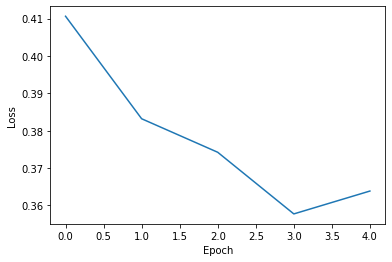

In [18]:
data_loc=("Data/train_data/*/*")
label_loc=("Data/train_label/")
workers=0
batch_size=10
loader_info=data1(data_loc,label_loc,batch_size,workers)

train(GNN(),get_dataloader(loader_info))

## GNN Testing

--->0
--->1
--->2
--->3


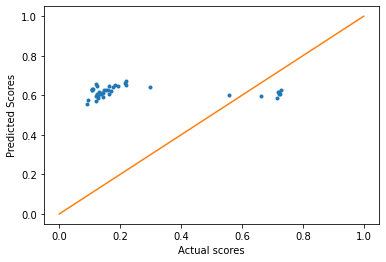

In [19]:
data_loc=("Data/test_data/*/*")
label_loc=("Data/test_label/")
workers=0
batch_size=10
temp=data1(data_loc,label_loc,batch_size,workers)
test(GNN(),get_dataloader(temp),'modelGCNL2_Global_Basic1.ckpt')    

### GNN performance on the training set

--->0
--->1
--->2
--->3
--->4
--->5


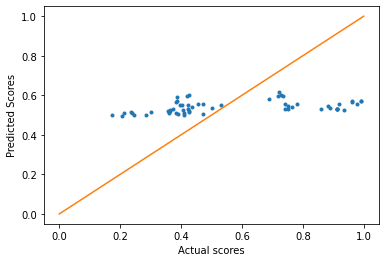

In [20]:
data_loc=("Data/train_data/*/*")
label_loc=("Data/train_label/")
workers=0
batch_size=10
temp=data1(data_loc,label_loc,batch_size,workers)
test(GNN(),get_dataloader(temp),'modelGCNL2_Global_Basic1.ckpt')    